# Восстановление золота из руды

Прототип модели машинного обучения для [«Цифры»](https://www.zyfra.com/ru/).

Цели:
* Подготовить данные.
* Провести исследовательский анализ данных.
* Построить и обучить модель, которая должна предсказывать коэффициент восстановления золота из золотосодержащей руды. 

Возможные значения для блока [этап]:
* rougher — флотация;
* primary_cleaner — первичная очистка;
* secondary_cleaner — вторичная очистка;
* final — финальные характеристики.

Возможные значения для блока [тип_параметра]:
* input — параметры сырья;
* output — параметры продукта;
* state — параметры, характеризующие текущее состояние этапа;
* calculation — расчётные характеристики.

# Подготовка данных

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [2]:
pd.options.display.float_format = '{:0.3f}'.format

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,
              rc={"lines.linewidth": 1.25})

plt.rcParams.update({"grid.linewidth":0.5,
                     "grid.alpha":0.5,
                     "figure.figsize": (8, 5)})

%config InlineBackend.figure_format = 'retina'

Загрузим и посмотрим данные.

In [3]:
try:
    train = pd.read_csv('gold_recovery_train_new.csv', parse_dates=['date'])
    test = pd.read_csv('gold_recovery_test_new.csv', parse_dates=['date'])
    full = pd.read_csv('gold_recovery_full_new.csv', parse_dates=['date'])
except:
    print('Не удалось загрузить файл, проверьте путь.')

Округлим время до ближайшего часа.

In [4]:
train.date = train.date.dt.round(freq='H')
test.date = test.date.dt.round(freq='H')
full.date = full.date.dt.round(freq='H')

train = train.set_index('date')
test = test.set_index('date')
full = full.set_index('date')

print(f'Gold recovery train\t- {train.shape}',
      f'Gold recovery test\t- {test.shape}',
      f'Gold recovery full\t- {full.shape}', sep='\n')

Gold recovery train	- (14149, 86)
Gold recovery test	- (5290, 52)
Gold recovery full	- (19439, 86)


## Поверочный расчет эффективности обогащения

Проверим расчет эффективности обогащения на обучающей выборке для признака найдя MAE между расчётами и полученнми из датафрейма значениями.

Различий нет вплоть до 14 знака после запятой, значит данные получены в соответствии с формулой:
> Recovery = C × (F – T) / [F × (C – T)], где:
>* C — доля золота в концентрате после флотации/очистки;
>* F — доля золота в сырье/концентрате до флотации/очистки;
>* T — доля золота в отвальных хвостах после флотации/очистки.

In [5]:
def recovery(rougher=True, df=train):
    if(rougher):
        return 100 * df['rougher.output.concentrate_au'] * (df['rougher.input.feed_au'] - df['rougher.output.tail_au']) \
               / (df['rougher.input.feed_au'] * (df[f'rougher.output.concentrate_au'] - df['rougher.output.tail_au']))
    else:
        return 100 * df['final.output.concentrate_au'] * (df['rougher.input.feed_au'] - df['final.output.tail_au']) \
               / (df['rougher.input.feed_au'] * (df['final.output.concentrate_au'] - df['final.output.tail_au']))

In [6]:
mean_absolute_error(train['rougher.output.recovery'], recovery())

1.1507086187862702e-14

In [7]:
mean_absolute_error(train['final.output.recovery'], recovery(False))

1.0116300177070741e-14

## Предобработка данных

В тестовой выборке отсутствуют целевые признаки output (параметры продукта) и calculation (расчётные характеристики). Также некоторые параметры недоступны в train выборке, потому что замеряются и/или рассчитываются значительно позже.

In [8]:
target_columns = set(c for c in train.columns).difference([c for c in test.columns])
target_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Расчетные характеристики получены из имеющихся признаков, поэтому их следует исключить при составлении модели чтобы избежать мультиколлинеарность.

In [9]:
(train['rougher.calculation.au_pb_ratio'] - train['rougher.input.feed_au'] / train['rougher.input.feed_pb']).sum()

8.073541835074138e-13

Тип данных количественный - float.

In [10]:
[full.dtypes.unique()]

[array([dtype('float64')], dtype=object)]

Определим суммарное число пропусков в выборках train и test.

In [11]:
print('Число NaN:', full.isna().sum().sum())

Число NaN: 4481


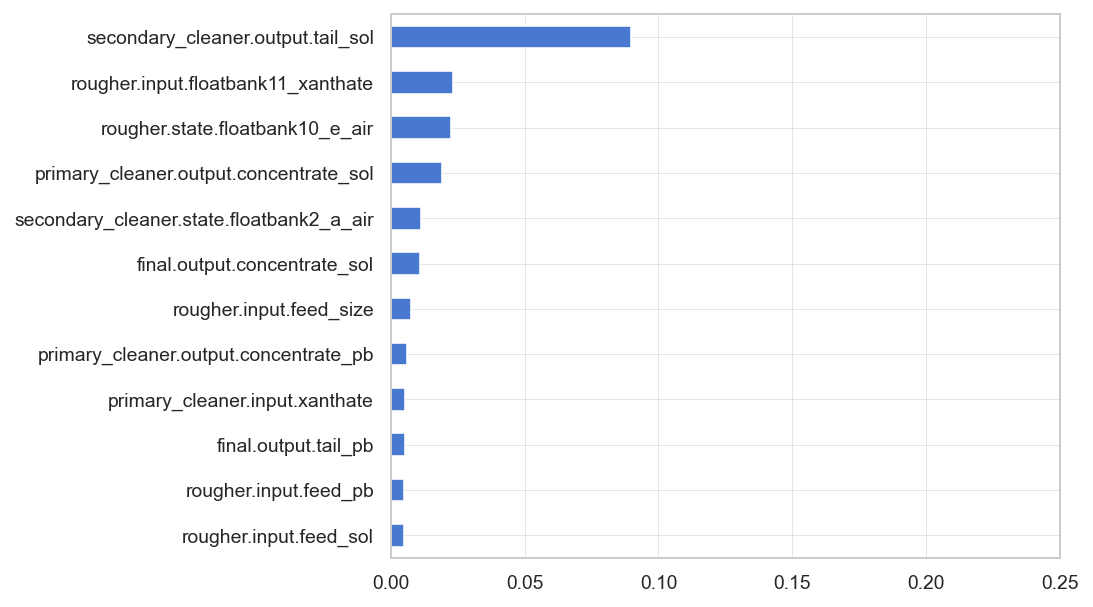

In [12]:
# Выводим только признаки в которых пропусков больше 0.5%.
full.isna().mean().sort_values() \
     .where(lambda x: x > 0.005) \
     .dropna() \
     .plot(kind='barh', figsize=(6,5), xlim=(0,0.25), xticks=np.linspace(0,0.25,6));

Сформируем словарь {этап.тип_параметра : признаки}.

In [13]:
query_columns = {}

for stage in ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']:
    for param in ['input', 'state', 'output']:
        query = f'{stage}.{param}'
        query_columns[query] = [c for c in full.columns if c.find(query) != -1]
        
display(query_columns)

{'rougher.input': ['rougher.input.feed_ag',
  'rougher.input.feed_pb',
  'rougher.input.feed_rate',
  'rougher.input.feed_size',
  'rougher.input.feed_sol',
  'rougher.input.feed_au',
  'rougher.input.floatbank10_sulfate',
  'rougher.input.floatbank10_xanthate',
  'rougher.input.floatbank11_sulfate',
  'rougher.input.floatbank11_xanthate'],
 'rougher.state': ['rougher.state.floatbank10_a_air',
  'rougher.state.floatbank10_a_level',
  'rougher.state.floatbank10_b_air',
  'rougher.state.floatbank10_b_level',
  'rougher.state.floatbank10_c_air',
  'rougher.state.floatbank10_c_level',
  'rougher.state.floatbank10_d_air',
  'rougher.state.floatbank10_d_level',
  'rougher.state.floatbank10_e_air',
  'rougher.state.floatbank10_e_level',
  'rougher.state.floatbank10_f_air',
  'rougher.state.floatbank10_f_level'],
 'rougher.output': ['rougher.output.concentrate_ag',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.concentrate_au',
  'rougher.output.recove

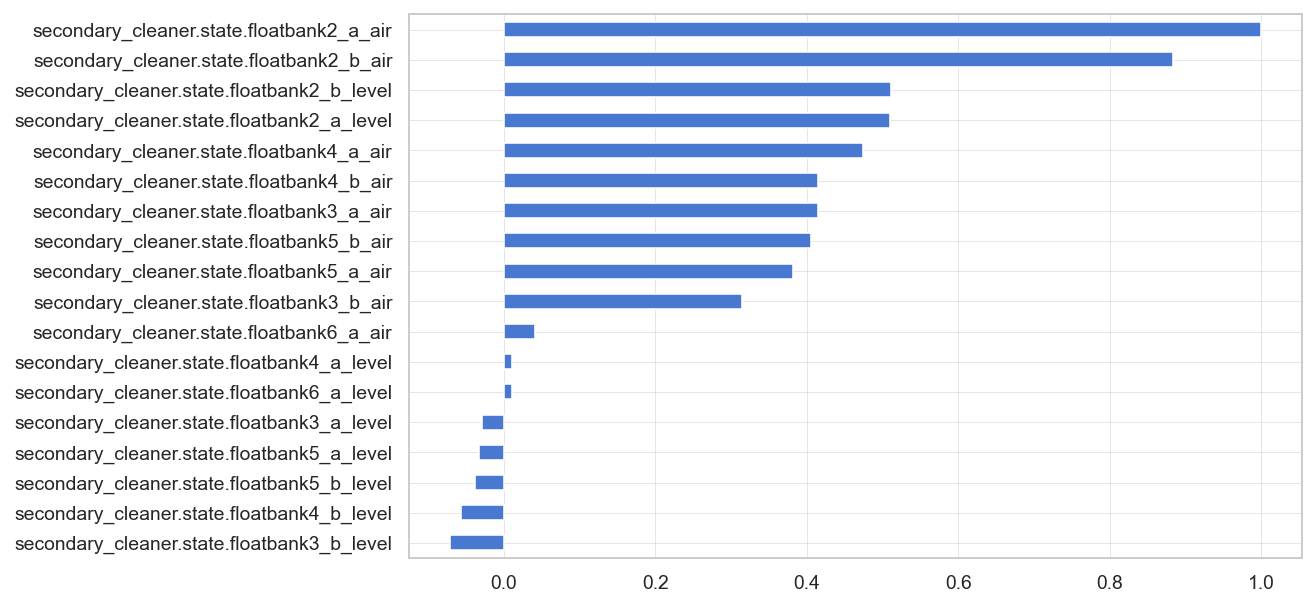

In [14]:
full[query_columns['secondary_cleaner.state']].corr()['secondary_cleaner.state.floatbank2_a_air'].sort_values().plot.barh();

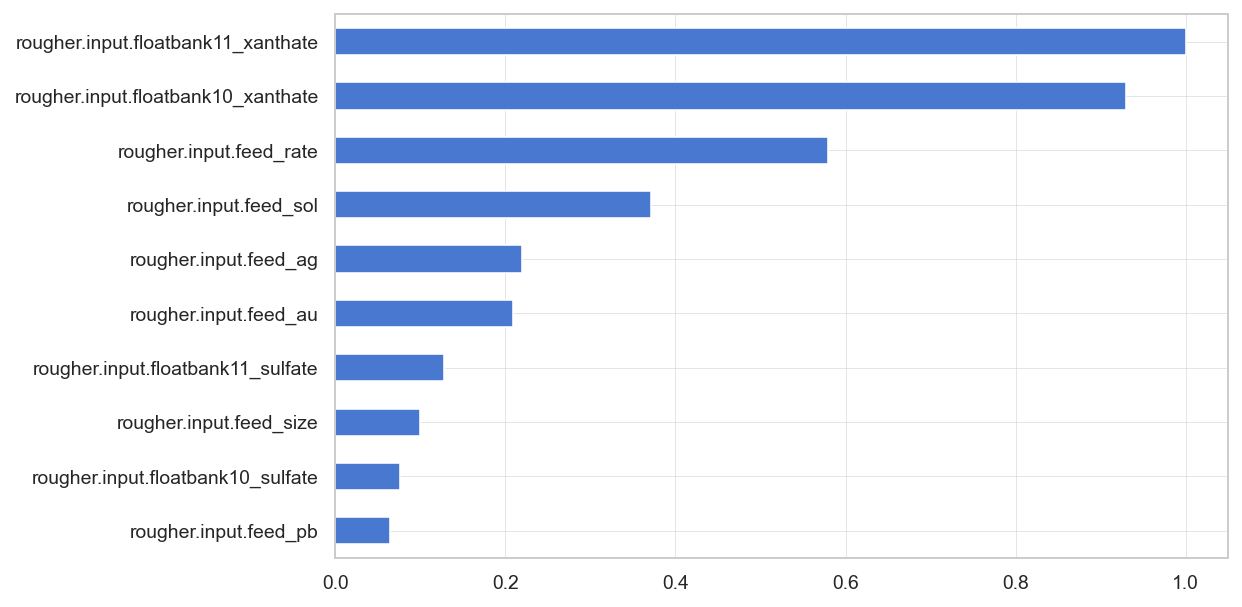

In [15]:
full[query_columns['rougher.input']].corr()['rougher.input.floatbank11_xanthate'].sort_values().plot.barh();

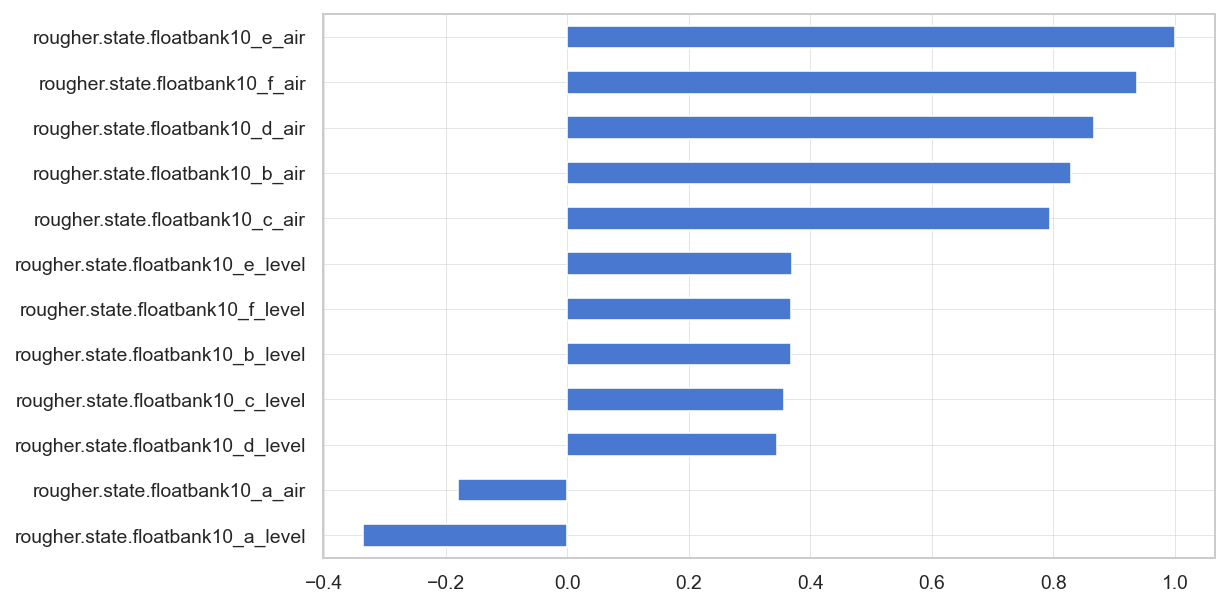

In [16]:
full[query_columns['rougher.state']].corr()['rougher.state.floatbank10_e_air'].sort_values().plot.barh();

Явных дубликатов в данных нет.

In [17]:
full.duplicated().sum()

0

## Выводы

* Выполнен поверочный расчет эффективности обогащения.
* Выявлены пропуски и способы их обработки.
    * Так как данные индексируются датой и временем получения информации (признак date), то соседние по времени параметры должны быть похожи. Поэтому для заполнения пропусков в дальнейшем используем функцией pandas interpolate.
    * Данные с пропусками в input в удалим, так как они относятся у основным.
    * Пропуски в floatbank2_a_air, floatbank11_xanthate и floatbank10_e_air заполнили соседними значениями из floatbank2_b_air, floatbank10_xanthate и floatbank10_f_air соответственно.

# Анализ данных

## График изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Из графика видно, что с каждым последующим этапом очистки концентрация золота возрастает, а серебра снижается. При этом концентрация ртути стабилизируется к первичной очистке около 10%.

Присутствует множество выбросов.

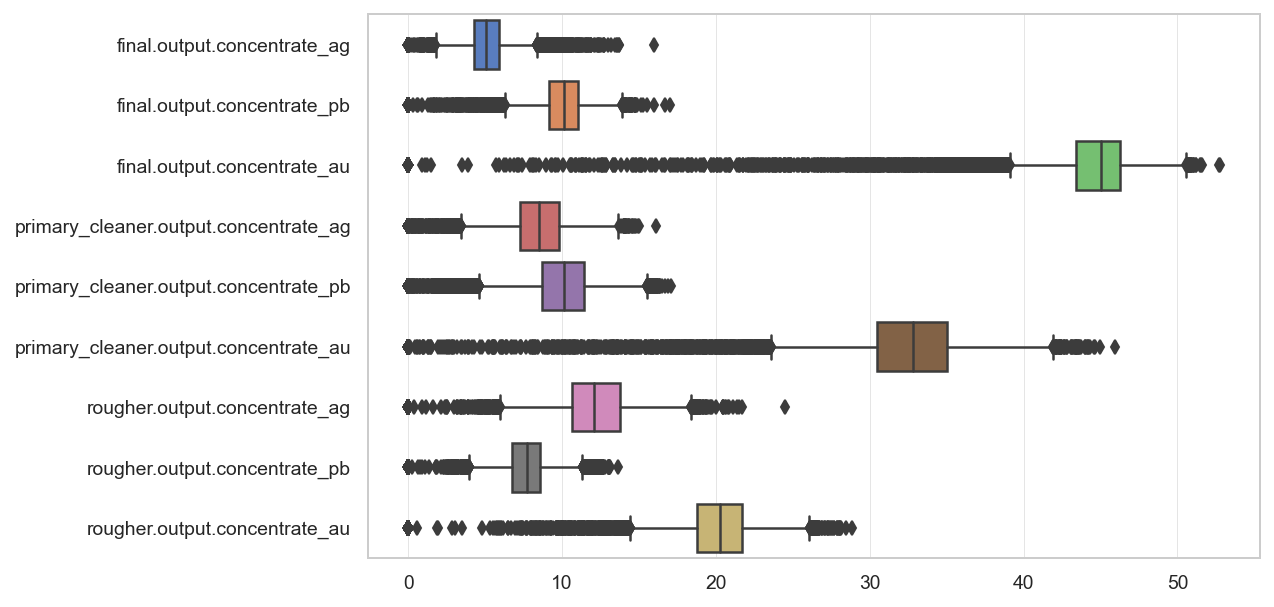

In [18]:
ax = sns.boxplot(data=full[
    [c for c in full.columns if c.endswith('concentrate', 0, -3)]
], orient='h')

## Диаграммы рассеивания и корреляция

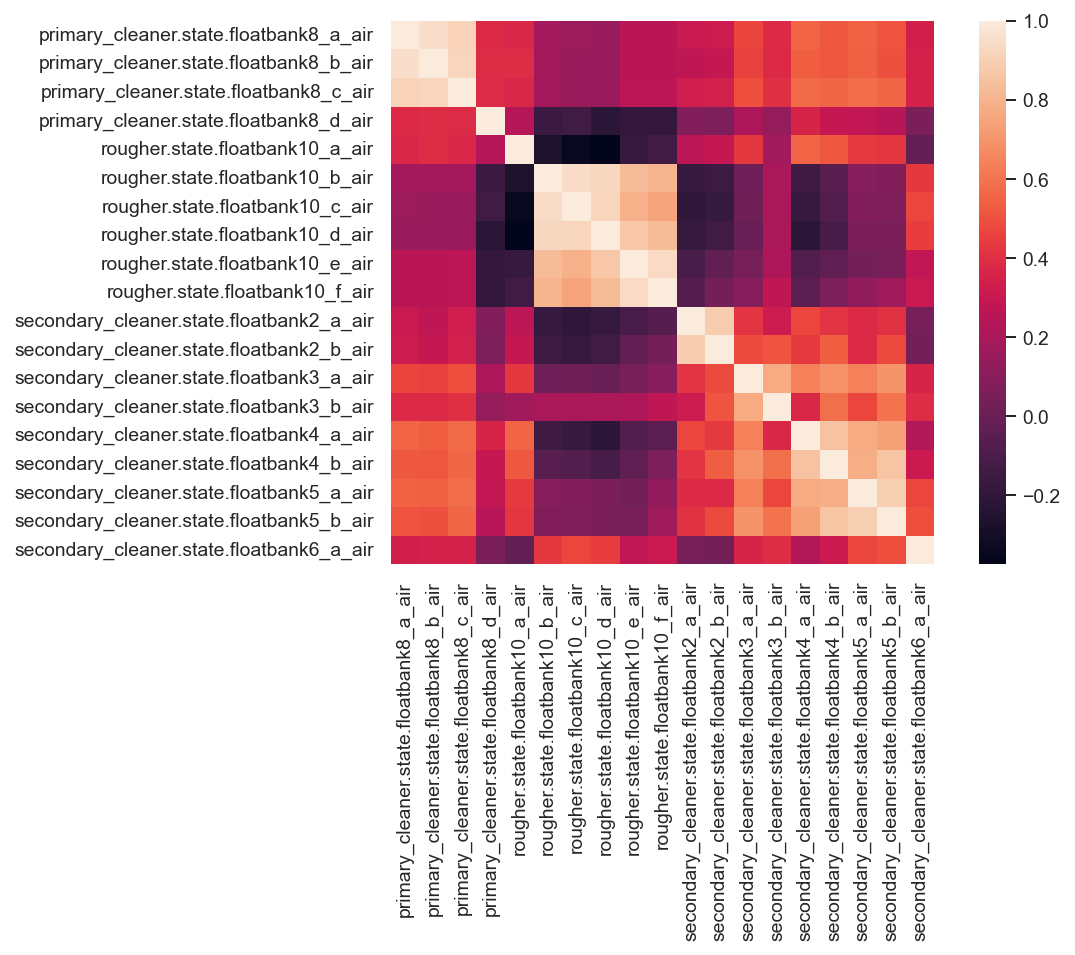

In [19]:
sns.heatmap(
    full[[c for c in full.columns if c.endswith('_air')]].corr(),
    square=True
);

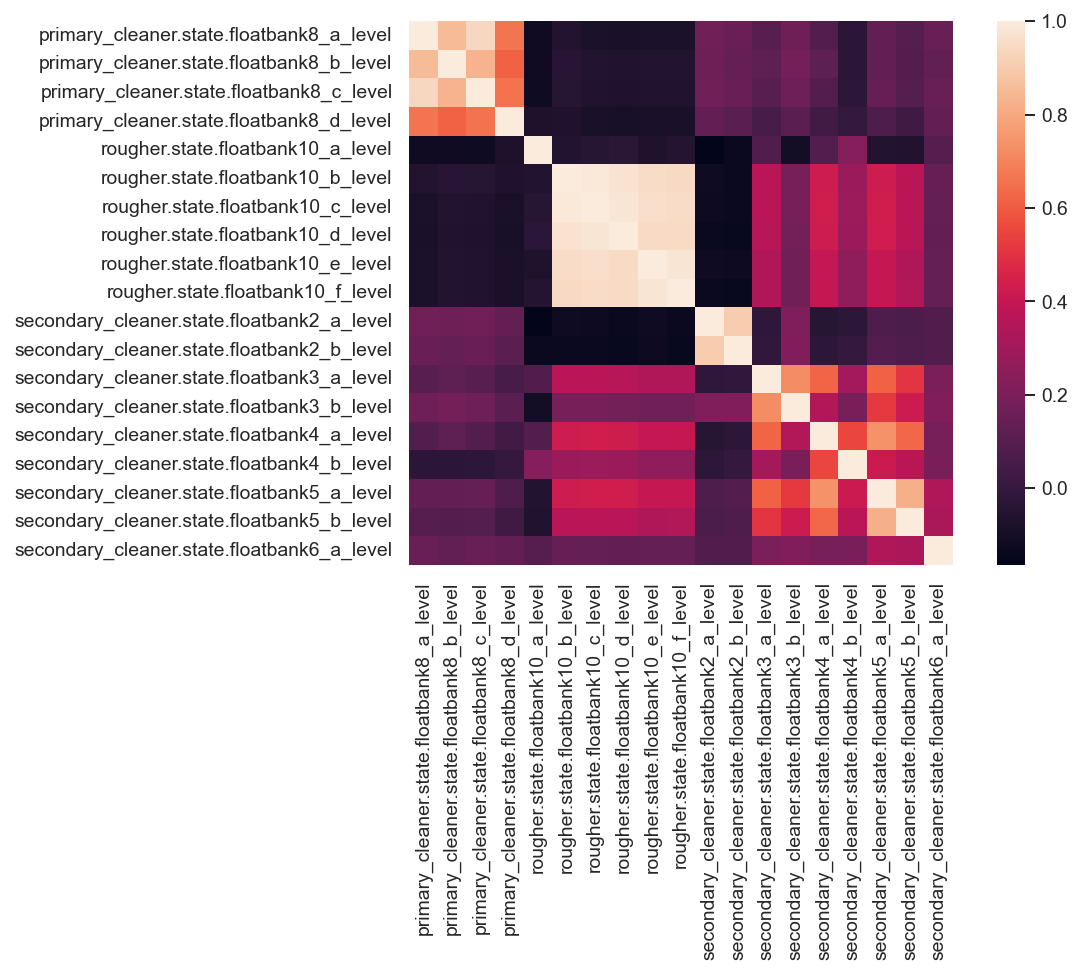

In [20]:
sns.heatmap(
    full[[c for c in full.columns if c.endswith('_level')]].corr(),
    square=True
);

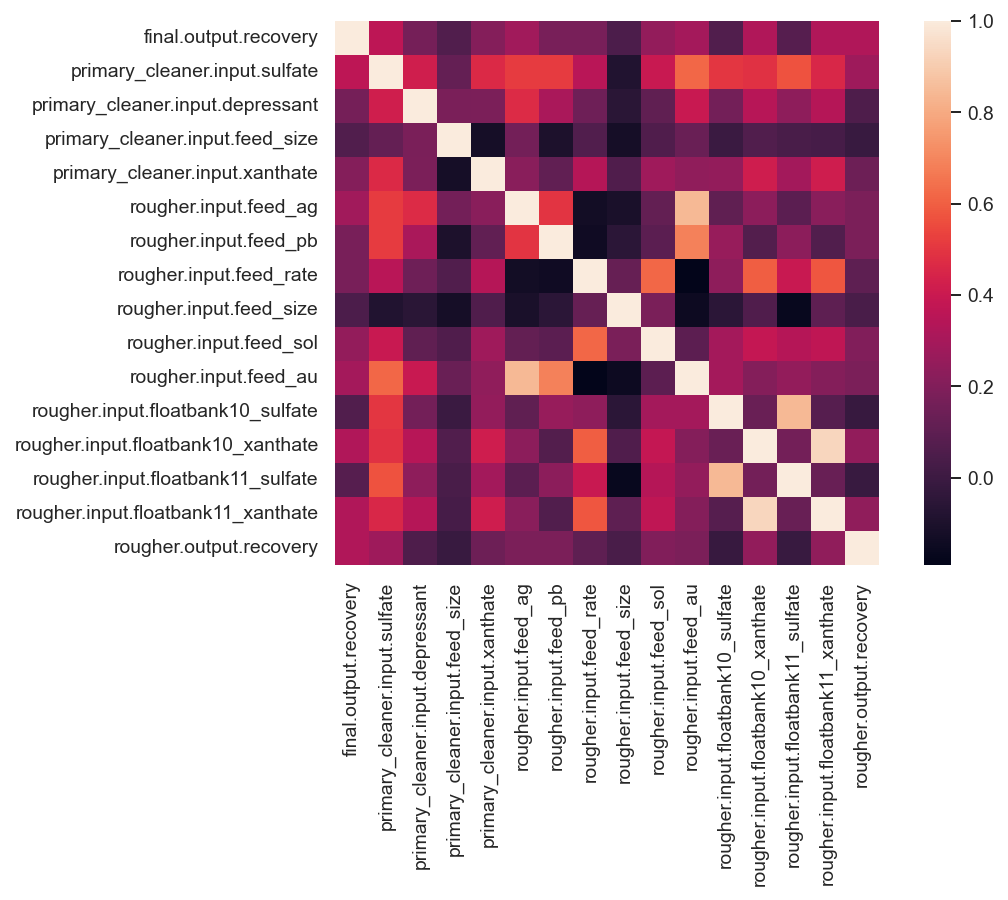

In [21]:
sns.heatmap(
    full[[c for c in full.columns if (c.find('input') != -1) | ((c.find('recovery') != -1))]].corr(),
    square=True
);

## Feature engineering

Объединим часть признаков, у которых высокая корреляция между собой.

In [22]:
# floatbanks - air
cols = [c for c in full.columns if (c.find('floatbank8') != -1) & (c.endswith(tuple(x + '_air' for x in 'abc')))]
full['primary_cleaner.state.floatbank8_abc_air'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

cols = [c for c in full.columns if (c.find('floatbank10') != -1) & (c.endswith(tuple(x + '_air' for x in 'bcdef')))]
full['primary_cleaner.state.floatbank10_bcdef_air'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

cols = [c for c in full.columns if (c.find('floatbank2') != -1) & (c.endswith(tuple(x + '_air' for x in 'ab')))]
full['primary_cleaner.state.floatbank2_ab_air'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

cols = [c for c in full.columns if (c.find('floatbank5') != -1) & (c.endswith(tuple(x + '_air' for x in 'ab')))]
full['primary_cleaner.state.floatbank5_ab_air'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

In [23]:
# floatbanks - level
cols = [c for c in full.columns if (c.find('floatbank8') != -1) & (c.endswith(tuple(x + '_level' for x in 'abc')))]
full['primary_cleaner.state.floatbank8_abc_level'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

cols = [c for c in full.columns if (c.find('floatbank10') != -1) & (c.endswith(tuple(x + '_level' for x in 'bcdef')))]
full['primary_cleaner.state.floatbank10_bcdef_level'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

cols = [c for c in full.columns if (c.find('floatbank2') != -1) & (c.endswith(tuple(x + '_level' for x in 'ab')))]
full['primary_cleaner.state.floatbank2_ab_level'] = full[cols].mean(axis=1)
full.drop(columns=cols, inplace=True)

## Исследование выходных данных

Коэффициенты восстановления равные 0 и 100 выглядят как ошибки в данных. Обнулим и приравняем данные соседним значениям.

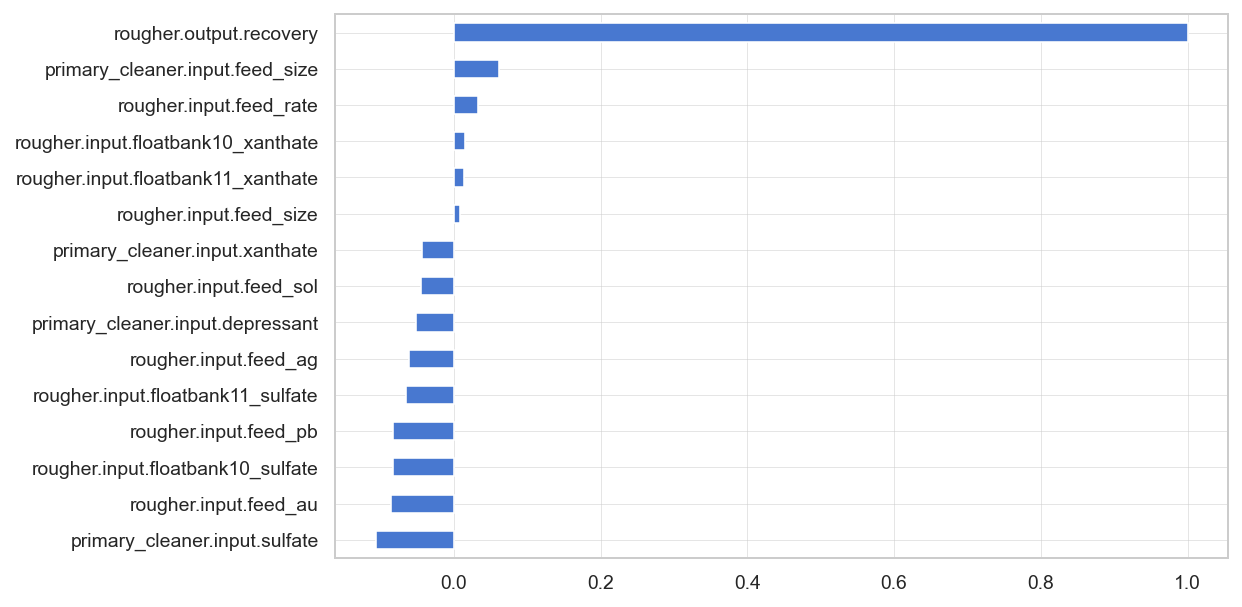

In [24]:
full[
    [c for c in full.columns if c.find('input') != -1] + ['rougher.output.recovery']
].query('@full["rougher.output.recovery"] < 5').corr()['rougher.output.recovery']\
    .sort_values().plot.barh();

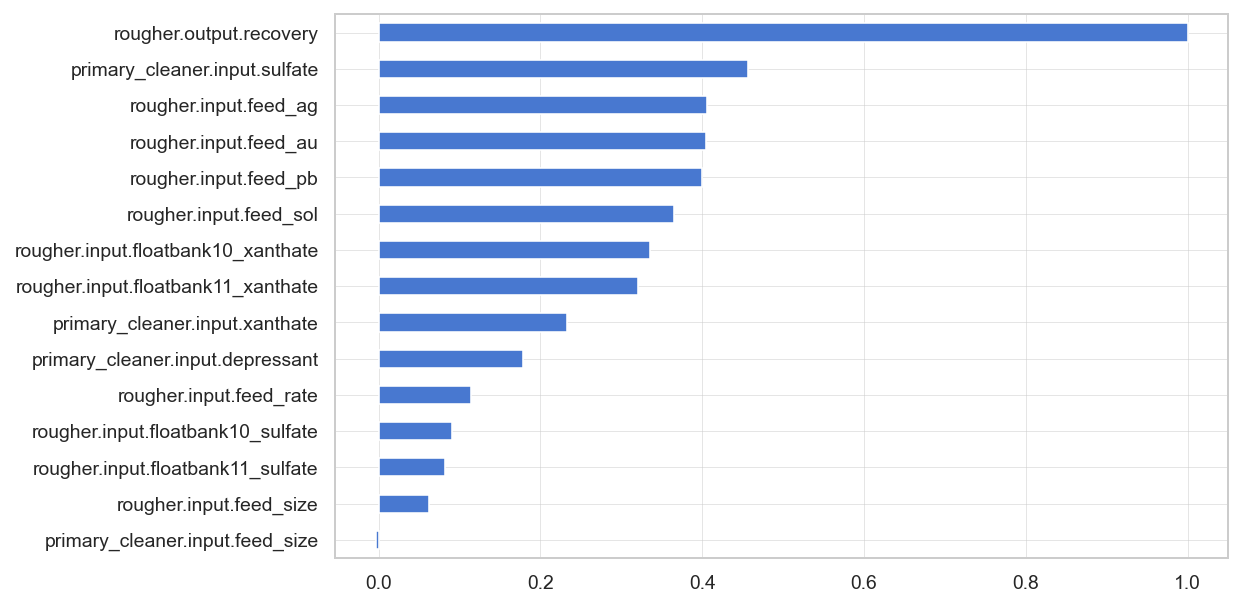

In [25]:
full[
    [c for c in full.columns if c.find('input') != -1] + ['rougher.output.recovery']
].query('@full["rougher.output.recovery"] >= 5').corr()['rougher.output.recovery']\
    .sort_values().plot.barh();

Видно, что для выбросов сильно изменяется корреляция целевого показателя с признаками.

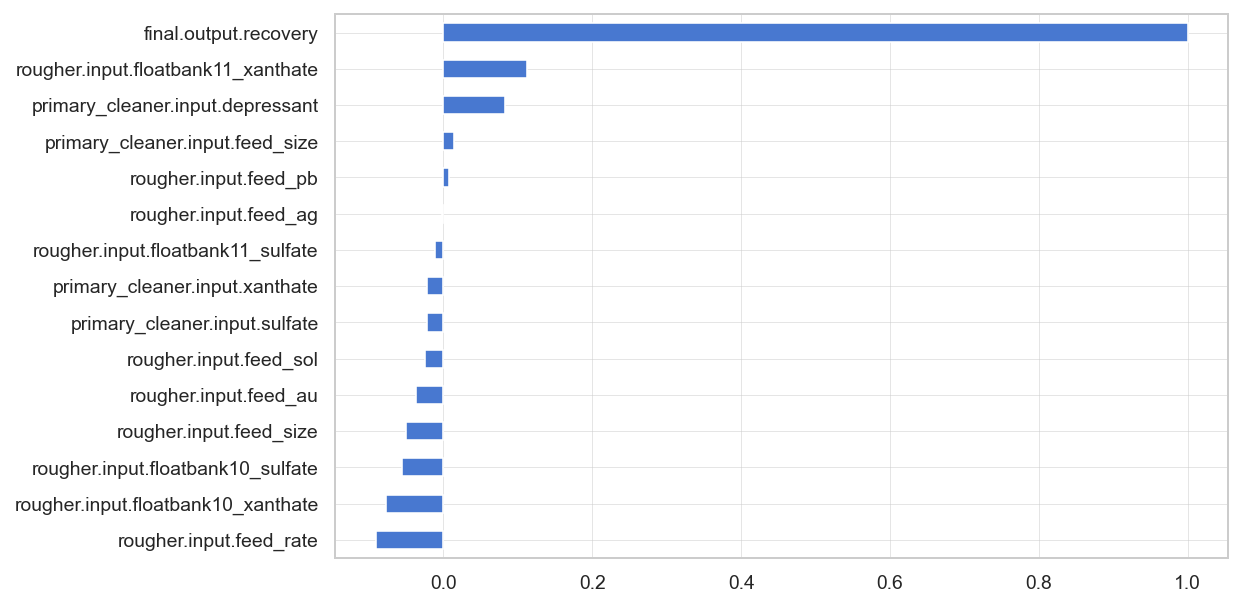

In [26]:
full[
    [c for c in full.columns if c.find('input') != -1] + ['final.output.recovery']
].query('@full["final.output.recovery"] >= 95').corr()['final.output.recovery'] \
    .sort_values().plot.barh();

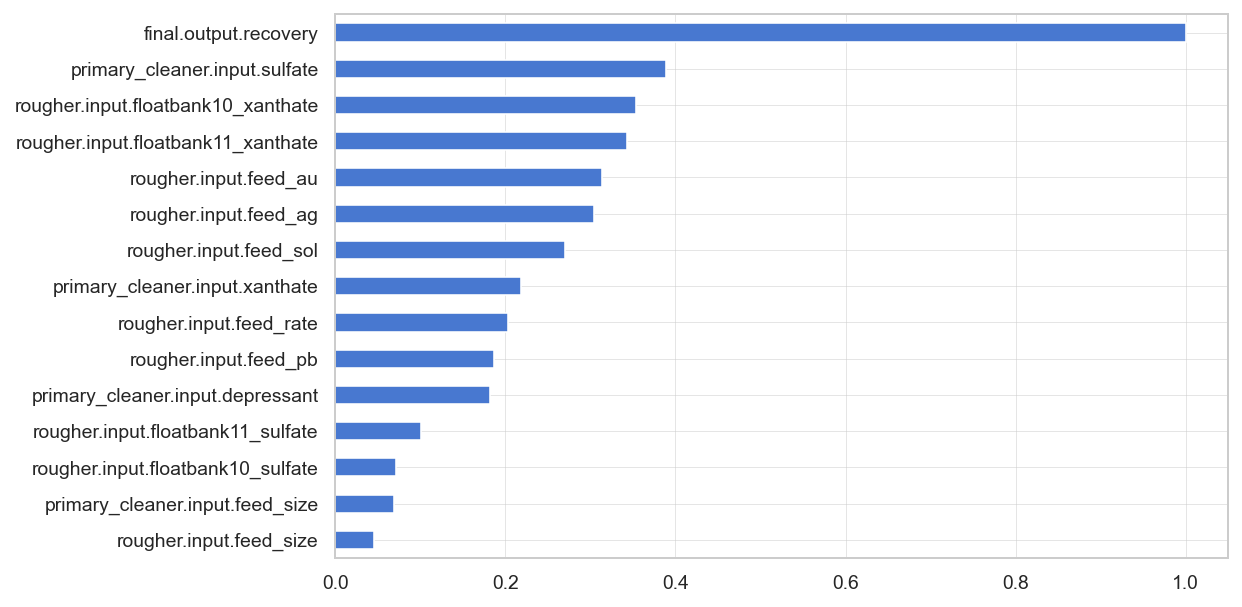

In [27]:
full[
    [c for c in full.columns if c.find('input') != -1] + ['final.output.recovery']
].query('@full["final.output.recovery"] < 95').corr()['final.output.recovery'] \
    .sort_values().plot.barh();

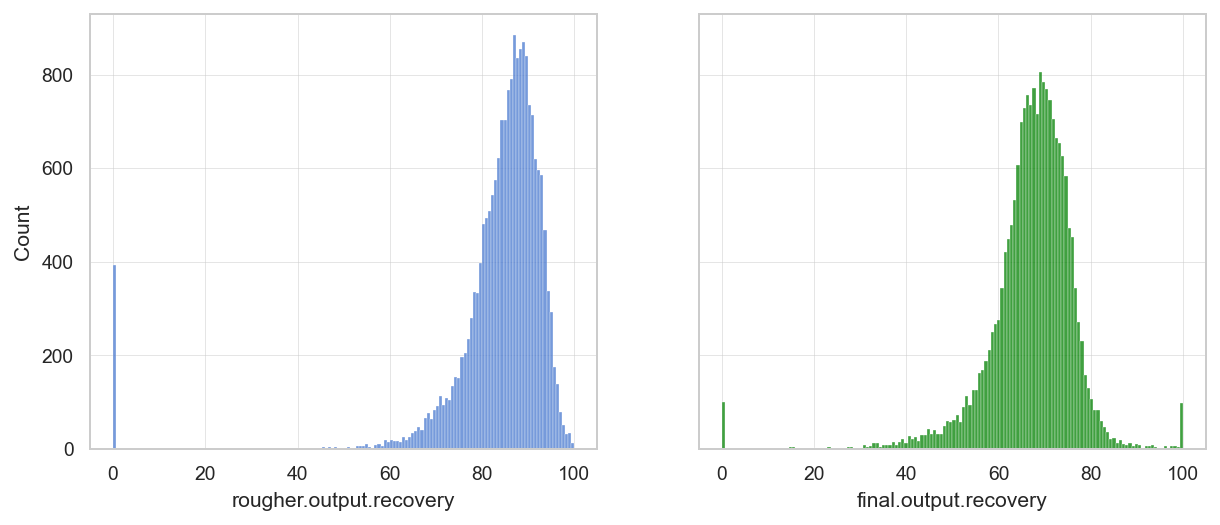

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

sns.histplot(full['rougher.output.recovery'], ax=axes[0])
sns.histplot(full['final.output.recovery'], color='green', ax=axes[1])

plt.show()

In [29]:
full.loc[:, 'final.output.recovery'] = \
    full.loc[:, 'final.output.recovery'] \
        .where(
            (full["final.output.recovery"] < 100)
            & (full["final.output.recovery"] > 20)
        )

In [30]:
full.loc[:, 'rougher.output.recovery'] = \
    full.loc[:, 'rougher.output.recovery'] \
        .where(
            full["rougher.output.recovery"] > 20
        )

In [31]:
full.query('@full["final.output.recovery"].isna() or @full["rougher.output.recovery"].isna()').shape[0]

624

Небольшие пропуски заполним методом interpolate, остальные удалим.

In [32]:
full.loc[:, ['final.output.recovery', 'rougher.output.recovery']] = \
    full.loc[:, ['final.output.recovery', 'rougher.output.recovery']].interpolate(method='time', limit=2)
full.query('@full["final.output.recovery"].isna() or @full["rougher.output.recovery"].isna()').shape[0]

355

In [33]:
full = full.query('~@full["final.output.recovery"].isna() and ~@full["rougher.output.recovery"].isna()')

## Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Визуализируем распределение размеров гранул.

> Заметно смещение тестовой выборки влево.

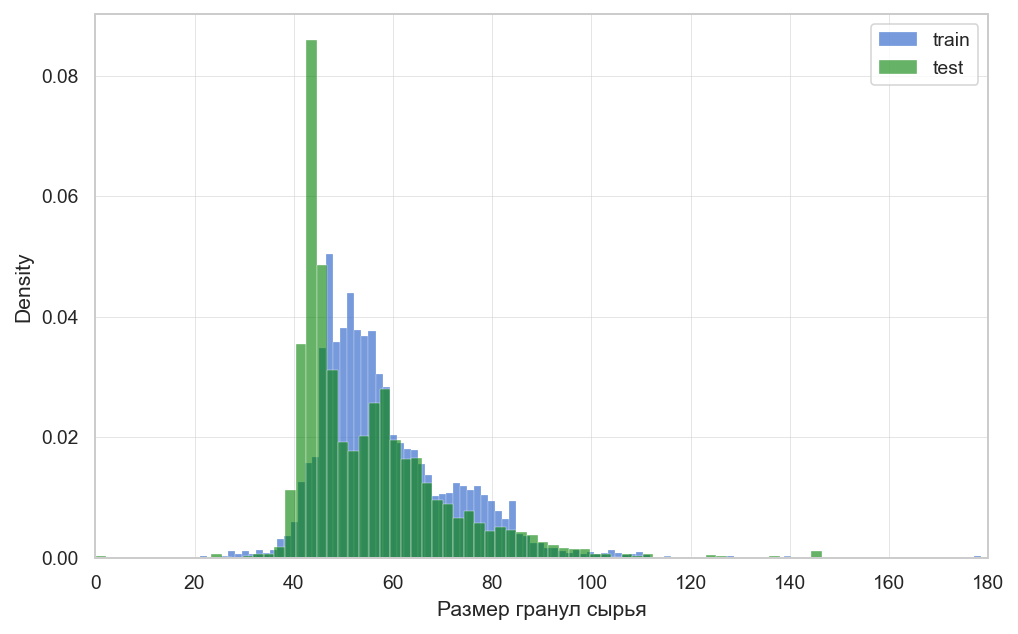

In [34]:
ax = sns.histplot(data=train['rougher.input.feed_size'], label='train',
                  stat='density')
sns.histplot(data=test['rougher.input.feed_size'],
             label='test', stat='density',
             color='green', alpha=0.6, ax=ax)

ax.set_xlim(0, 180)
plt.legend()
plt.xlabel('Размер гранул сырья')
plt.show()

Проверим гипотезу о равенстве средних двух выборок.

> * Нулевая гипотеза h<sub>0</sub> - средние размеры гранул сырья на обучающей и тестовой выборках одинаковые.
> * Альтернативная гипотеза h<sub>1</sub> - средние размеры гранул сырья на обучающей и тестовой выборках отличаются.

In [35]:
# Используем ttest_ind для двух независимых выборок.
results = st.ttest_ind(train['rougher.input.feed_size'],
                       test['rougher.input.feed_size'], nan_policy='omit')
# Тест двухсторонний.
print('p-значение:', results.pvalue)

p-значение: 7.865316540592686e-33


**Отвергаем гипотезу о равенстве средних, так как p-value ниже порогового значения alpha (<0.05).**

Средние распределений отличаются на ~7%. А как известно, если распределения сильно отличаются друг от друга, оценка модели может быть неправильной. Учтем это при построении модели.

In [36]:
(train['rougher.input.feed_size'].mean() - test['rougher.input.feed_size'].mean()) / train['rougher.input.feed_size'].mean()

0.06919621952959064

## Исследование суммарной концентрации всех веществ на разных стадиях

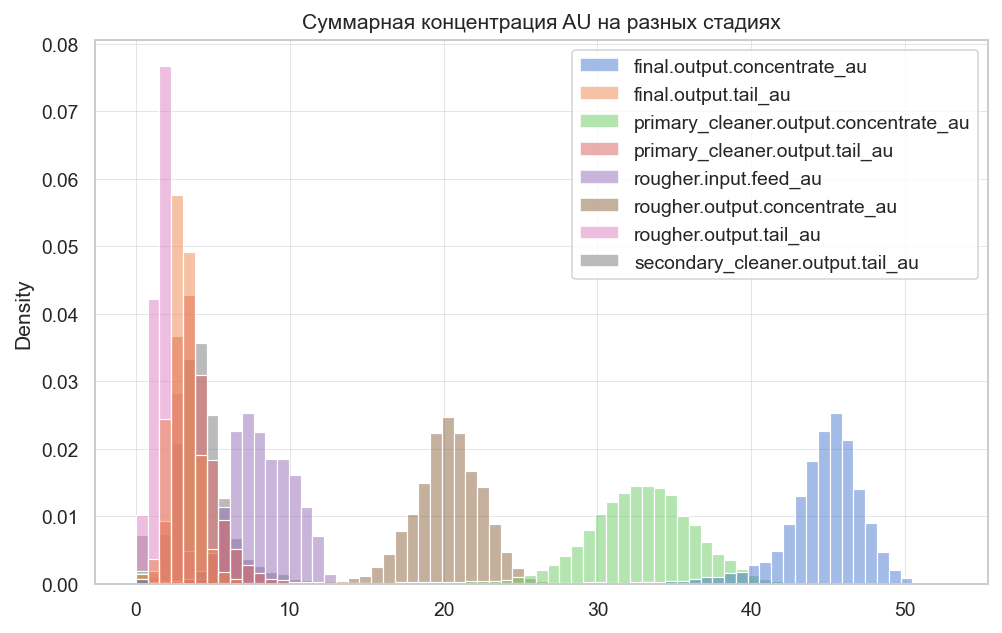

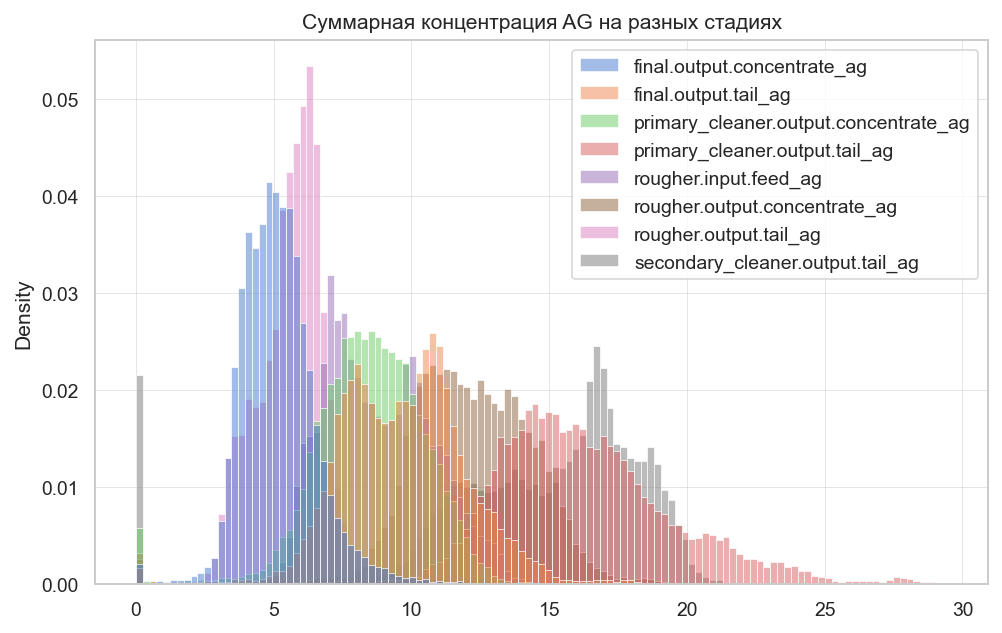

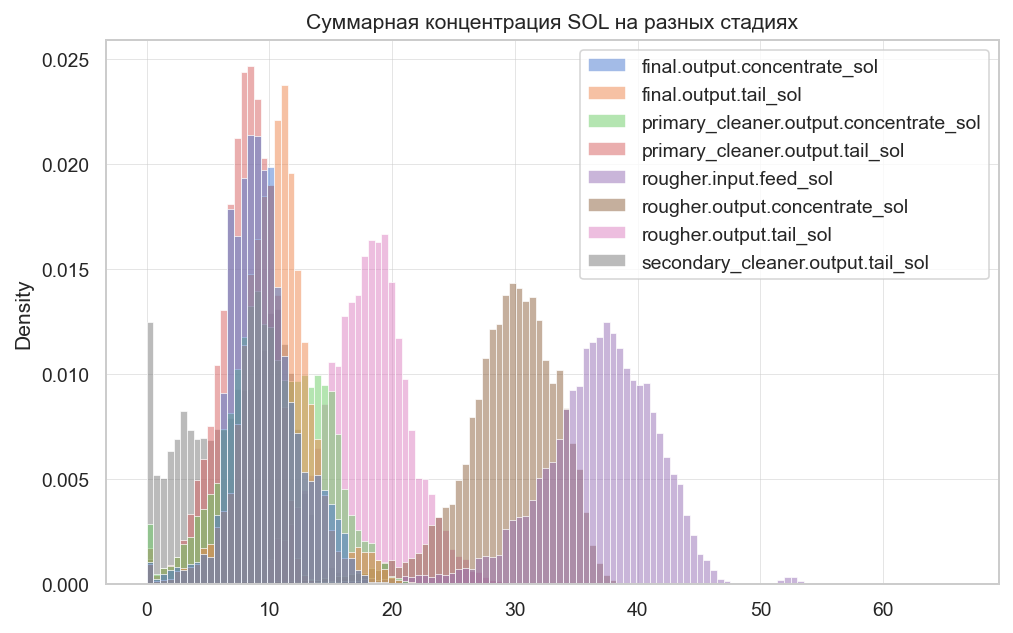

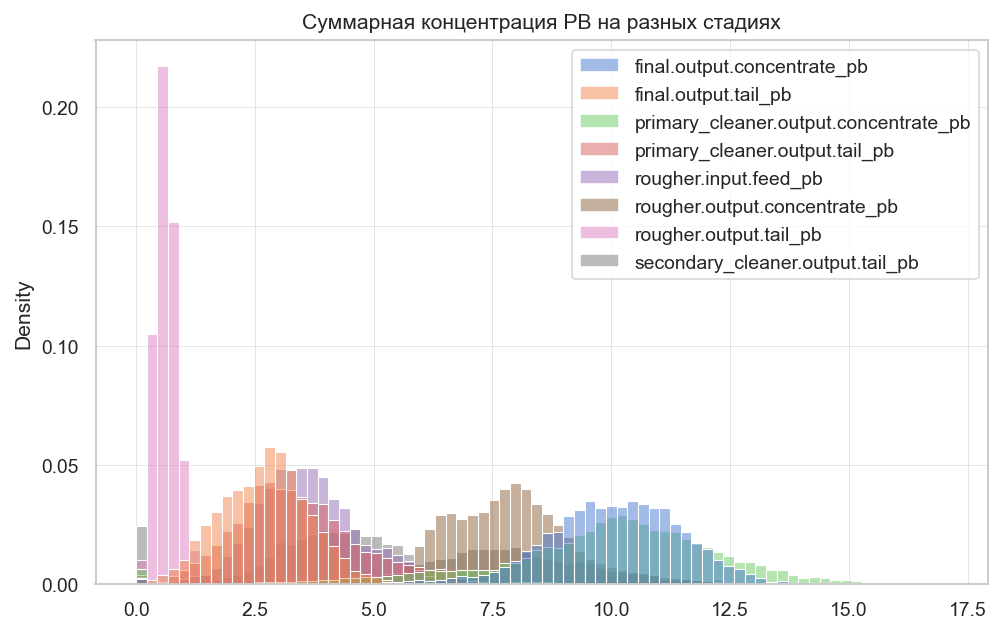

In [37]:
for e in ['_au', '_ag', '_sol', '_pb']:
    ax = sns.histplot(data=full[
        [c for c in full.columns if c.endswith((e))]
    ], stat='density')
    
    plt.title(f'Суммарная концентрация {e.strip("_").upper()} на разных стадиях')
    plt.show()

Отфильтруем датафрейм оставив только концентрации веществ. Дополнительно сгруппируем данные по дате, взяв средние за день значения.

In [38]:
filtered_train = full[
    [c for c in full.columns if c.endswith(('_ag', '_pb', '_sol', '_au'))]
].groupby(full.index.date).mean()

Изменение суммарной концентрации всех компонентов на разных этапах (флотация, первичная очистка, вторичная очистка) по дням. Графики приведены без учета отвальных хвостов.

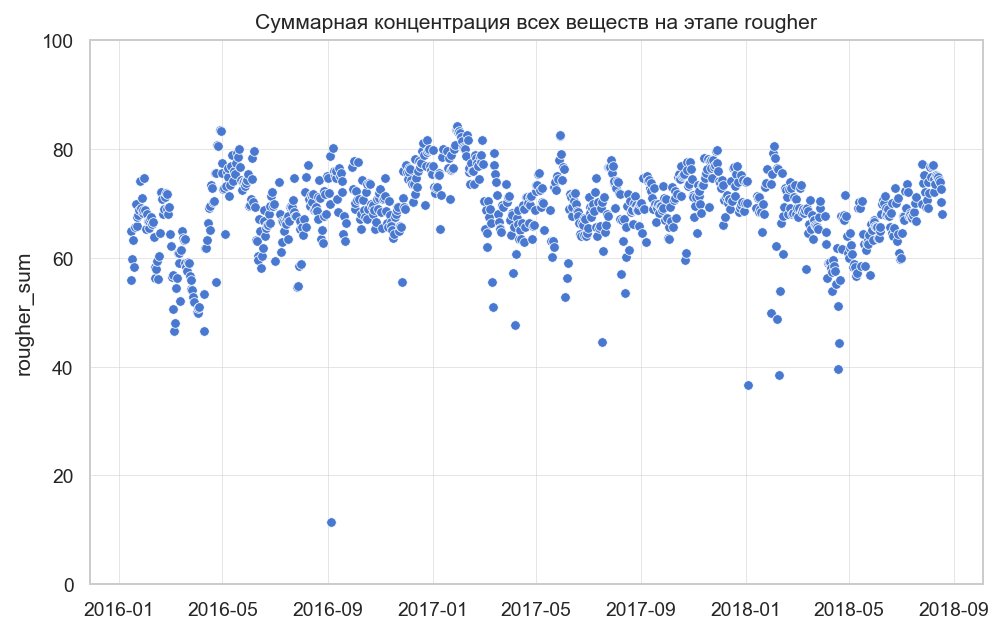

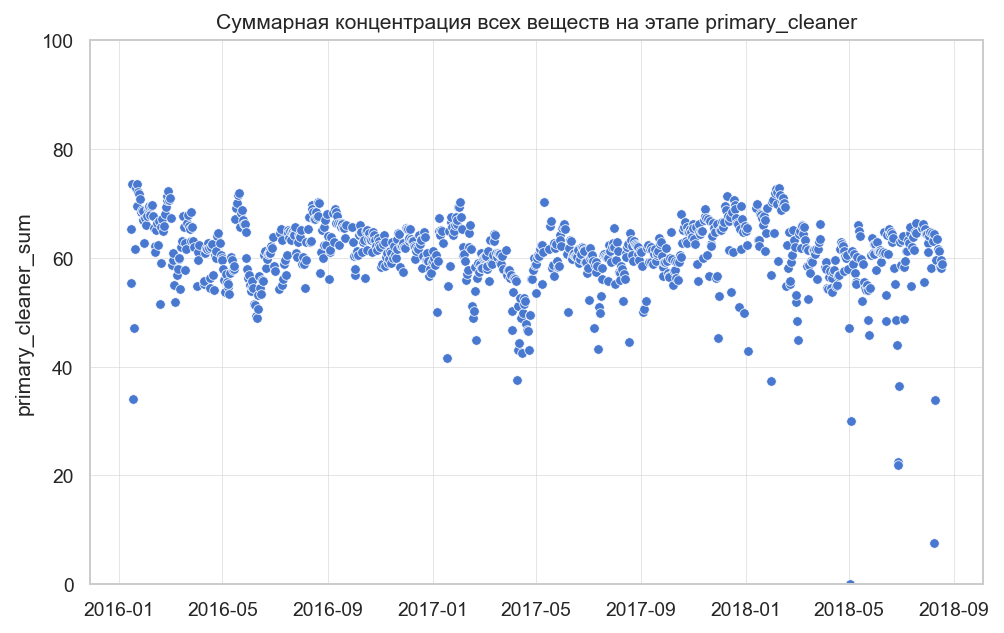

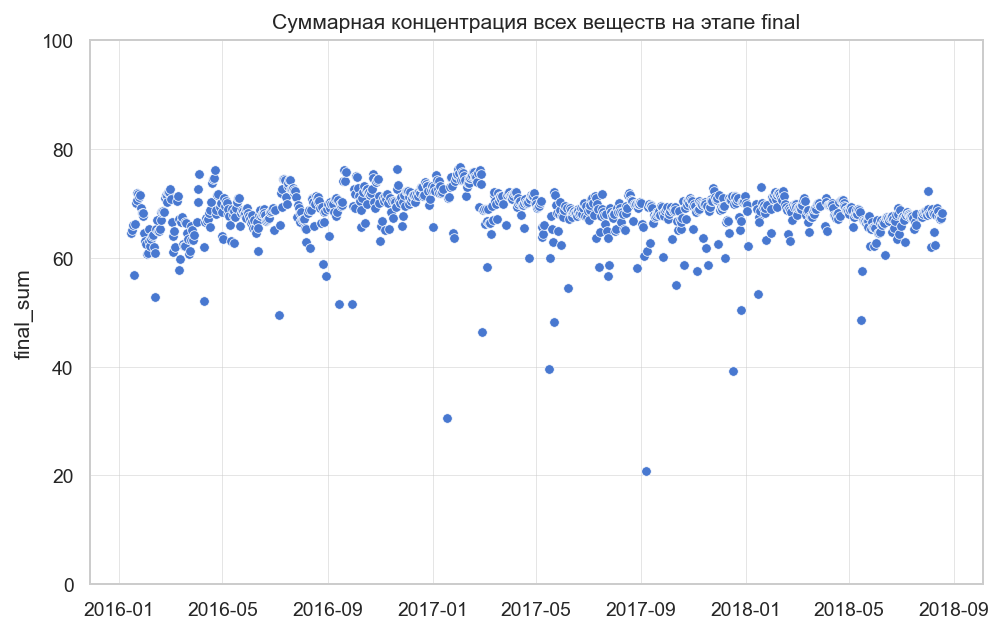

In [39]:
for i, stage in enumerate(['rougher', 'primary_cleaner', 'final']):
    
    filtered_train[stage + '_sum'] = filtered_train[
        [c for c in filtered_train.columns if c.find(stage + '.output.concentrate') != -1]
    ].apply(lambda x: sum(x), raw=True, axis=1)
    
    ax = sns.scatterplot(
        y=filtered_train[stage + '_sum'],
        x=filtered_train.index
    )
    
    plt.title(f'Суммарная концентрация всех веществ на этапе {stage}')
    plt.ylim(0,100)
    plt.show()

Будем считать выбросами данные с концентрациями ниже определенного порога.

In [40]:
# Удаляются те данные, в которых дата индеска train совпадает с индексом filtered_train.
print(full.shape)

full = full[~full.index.floor("D").isin(
    filtered_train.query('rougher_sum < 45 \
                         or primary_cleaner_sum < 40 \
                         or final_sum < 50').index
)]

print(full.shape)

(19084, 71)
(18741, 71)


## Выводы

* Выполнена генерация признаков.
* Исследованы концентрации веществ.
    * Выявлен рост концентрации золота по мере очистки.
    * Концентрация веществ выше на этапе флотации и колеблется на уровне 60-70%.

# Модель

Заполним нулевые значения ближайшими.

In [41]:
full = full.interpolate(method='time', limit=12)
full.loc[full['rougher.input.floatbank11_xanthate'].isna(), 'rougher.input.floatbank11_xanthate'] = \
    full.loc[full['rougher.input.floatbank11_xanthate'].isna(), 'rougher.input.floatbank10_xanthate']

Так как задача на временные ряды, то включим output и recovery за предыдущий час в features.

In [42]:
output = full[target_columns].iloc[:-1, :].copy()
output.index = output.index + pd.Timedelta(1, 'h')
output.columns = [x+'_1h' for x in output.columns]

full = full.iloc[1:, :].join(output)

Отделим features от target.

In [43]:
divider = round(full.shape[0] * 0.75)

features = full[set(full.columns).difference(target_columns)]
target = full[['rougher.output.recovery', 'final.output.recovery']]

print('features, rougher, final: ',
      features.shape, target.iloc[:, 0].shape, target.iloc[:, 1].shape)

features, rougher, final:  (18740, 71) (18740,) (18740,)


Функция расчёта симметричной средней абсолютной ошибки в процентах.

In [44]:
def sMAPE_loss(y_true, y_pred):
    return 100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

sMAPE_scorer = make_scorer(sMAPE_loss, greater_is_better=False)

## Обучение моделей и оценка их качества кросс-валидацией

Формируем пайплайн в котором применим устойчивый к выбросам RobustScaler и PCA для уменьшения числа измерений.

In [45]:
# Модель.
model = CatBoostRegressor(verbose=False,
                          thread_count=8,
                          random_state=38,
                          iterations=320)

# Сетка гиперпараметров для подбора.
param_grid = {
    'catboostregressor__depth': range(3, 8),
    'catboostregressor__learning_rate': [0.01, 0.025, 0.05, 0.1],
}

Найдем sMAPE для этапа флотации.

In [46]:
pipe = make_pipeline(MinMaxScaler(), model)

search = GridSearchCV(
    pipe,
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring=sMAPE_scorer,
    n_jobs=-1,
)

In [47]:
search.fit(
    features.iloc[:divider, :],
    target.iloc[:divider, 0]
)
print(search.best_params_)
print(f'sMAPE: {-search.cv_results_["mean_test_score"].max()/100:.2%}')

{'catboostregressor__depth': 3, 'catboostregressor__learning_rate': 0.025}
sMAPE: 2.44%


In [48]:
sMAPE_rougher = sMAPE_loss(target.iloc[divider:, 0],
                           search.best_estimator_.predict(features.iloc[divider:, :]))

Найдем sMAPE для финального этапа.

In [49]:
pipe = make_pipeline(StandardScaler(), model)

search = GridSearchCV(
    pipe,
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring=sMAPE_scorer,
    n_jobs=-1,
)

In [50]:
search.fit(
    features.iloc[:divider, :],
    target.iloc[:divider, 1]
)
print(search.best_params_)
print(f'sMAPE: {-search.cv_results_["mean_test_score"].max()/100:.2%}')

{'catboostregressor__depth': 3, 'catboostregressor__learning_rate': 0.025}
sMAPE: 4.58%


In [51]:
sMAPE_final = sMAPE_loss(target.iloc[divider:, 1],
                         search.best_estimator_.predict(features.iloc[divider:, :]))

Посчитаем итоговое sMAPE.

In [52]:
sMAPE_total = 0.25*sMAPE_rougher + 0.75*sMAPE_final
print(f'sMAPE_rougher:\t{sMAPE_rougher/100:.2%}')
print(f'sMAPE_final:\t{sMAPE_final/100:.2%}')
print(''.center(21,'═'))
print(f'sMAPE_total:\t{sMAPE_total/100:.2%}')

sMAPE_rougher:	2.66%
sMAPE_final:	5.31%
═════════════════════
sMAPE_total:	4.65%


Сравним с DummyRegressor.

In [53]:
(
    0.25 * sMAPE_loss(target.iloc[divider:, 0],
           DummyRegressor(strategy="median")
               .fit(features.iloc[:divider, :], target.iloc[:divider, 0])
               .predict(features.iloc[divider:, :])) +
    0.75 * sMAPE_loss(target.iloc[divider:, 1],
           DummyRegressor(strategy="median")
               .fit(features.iloc[:divider, :], target.iloc[:divider, 1])
               .predict(features.iloc[divider:, :]))
)

9.587117658638983

# Выводы:
    
* Построена и обучена модель.
* Выполнена кросс-валидация.
* Найдены оптимальные гиперпараметры.
* Низкие концентрации веществ и превышения final recovery над rougher мог служить триггерами аномального процесса.
* Посчитан итоговый sMAPE - 4.6%, что можно считать неплохим показателем. Близкий результат дает линейная модель ElasticNet, которая может рассматриваться в качестве альтернативы CatBoostRegressor из-за простоты и скорости.